In [1]:
import os
import json
from datasets import load_dataset



In [2]:
system_message = """You are a Vision Language Model specialized in interpreting visual data from chart images.
Your task is to analyze the provided chart image and title, then respond with IELTS Band 9 essay about the data.
You use sofisticated vocabulary and correct grammar, moreover you use synonyms and you do not repeat words."""

In [3]:
def format_data(sample):
    return [
        {
            "role": "system",
            "content": [
                {
                    "type": "text",
                    "text": system_message
                }
            ],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": sample["image"],
                },
                {
                    "type": "text",
                    "text": sample['title'] ,
                }
            ],
        },
        {
            "role": "assistant",
            "content": [
                {
                    "type": "text",
                    "text": sample["essay"]
                }
            ],
        },
    ]

In [4]:
!pip install  -U -q transformers trl datasets bitsandbytes peft accelerate

In [5]:
!pip install -q wheel

In [5]:
!pip install -q tensorboardX

In [ ]:
!pip install -q wheel flash-attn --no-build-isolation

In [6]:
from huggingface_hub import login
hub_key=os.getenv('HUGGINGFACE_HUB')
login(token=hub_key)

In [7]:
dataset = load_dataset("szymmon/SmolVLM_Essay_Database")

shuffled_dataset = dataset['train'].shuffle(seed=42)

# Simple 70-15-15 split
total_size = len(shuffled_dataset)
train_dataset, test_dataset, eval_dataset = shuffled_dataset.select(range(int(0.7*total_size))), shuffled_dataset.select(range(int(0.7*total_size), int(0.85*total_size))), shuffled_dataset.select(range(int(0.85*total_size), total_size))


## Format for chatbot structure

In [8]:
train_dataset = [format_data(sample) for sample in train_dataset]
eval_dataset = [format_data(sample) for sample in eval_dataset]
test_dataset = [format_data(sample) for sample in test_dataset]

In [9]:
train_dataset[0]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision Language Model specialized in interpreting visual data from chart images.\nYour task is to analyze the provided chart image and title, then respond with IELTS Band 9 essay about the data.\nYou use sofisticated vocabulary and correct grammar, moreover you use synonyms and you do not repeat words.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=800x557>},
   {'type': 'text',
    'text': 'Number of passengers denied boarding  by the largest U.S. air carriers   from 1990 to 2019 ( in 1,000s )\n'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': 'The bar chart illustrates the number of passengers denied boarding by the largest U.S. air carriers from 1990 to 2019, measured in thousands.\n\nThe data reveals a fluctuating trend in the number of passengers denied boarding over the three decades. The highest number of denie

In [10]:
print(train_dataset[1][2]['content'][0]['text'])

The bar chart illustrates the annual salaries of the ten best-paid French sportsmen in 2018, measured in millions of euros.

Antoine Griezmann leads the ranking with an annual salary of 33 million euros, significantly higher than the second-highest earner, Kylian Mbappé, who earns 24.7 million euros. Paul Pogba and Karim Benzema follow closely, with salaries of 22.1 million euros and 22 million euros respectively.

Nicolas Batum and Rudy Gobert, both basketball players, earn 20.9 million euros and 20.6 million euros respectively. Ousmane Dembélé, another football player, earns 19.1 million euros. Joakim Noah and Evan Fournier, also basketball players, earn 17.5 million euros and 15.2 million euros respectively. Franck Ribéry, the last on the list, earns 14.3 million euros.

Overall, football players dominate the top of the list, with Antoine Griezmann and Kylian Mbappé being the highest earners. Basketball players also feature prominently, with Nicolas Batum and Rudy Gobert earning sub

In [36]:
print(train_dataset[1][1]['content'][1]['text'])

Ranking of the ten best-paid French sportsmen in 2018  ( in million euros )



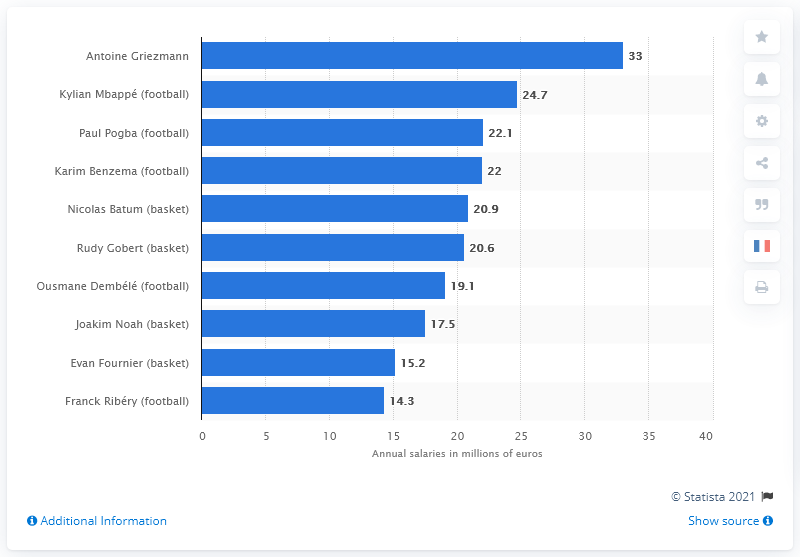

In [37]:
train_dataset[1][1]['content'][0]['image']

## Load model

In [11]:
import torch
from transformers import Idefics3ForConditionalGeneration, AutoProcessor

model_id = "HuggingFaceTB/SmolVLM-Instruct"

In [12]:
def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device="cuda"):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        sample[1:2],  # Use the sample without the system message
        add_generation_prompt=True
    )

    image_inputs = []
    image = sample[1]['content'][0]['image']
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image_inputs.append([image])

    # Prepare the inputs for the model
    model_inputs = processor(
        #text=[text_input],
        text=text_input,
        images=image_inputs,
        return_tensors="pt",
    ).to(device)  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

In [13]:
import gc
import time

def clear_memory():
    # Delete variables if they exist in the current global scope
    if 'inputs' in globals(): del globals()['inputs']
    if 'model' in globals(): del globals()['model']
    if 'processor' in globals(): del globals()['processor']
    if 'trainer' in globals(): del globals()['trainer']
    if 'peft_model' in globals(): del globals()['peft_model']
    if 'bnb_config' in globals(): del globals()['bnb_config']
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

clear_memory()

/home/user/Essay_LLM_Distillation/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


GPU allocated memory: 0.00 GB
GPU reserved memory: 0.00 GB


## Fine-Tuning

In [14]:
from transformers import BitsAndBytesConfig

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    # _attn_implementation="flash_attention_2",
)
processor = AutoProcessor.from_pretrained(model_id)

In [15]:
from peft import LoraConfig, get_peft_model

# Configure LoRA
peft_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules=['down_proj','o_proj','k_proj','q_proj','gate_proj','up_proj','v_proj'],
    use_dora=True,
    init_lora_weights="gaussian"
)

# Apply PEFT model adaptation
peft_model = get_peft_model(model, peft_config)

# Print trainable parameters
peft_model.print_trainable_parameters()

trainable params: 11,269,248 || all params: 2,257,542,128 || trainable%: 0.4992


In [16]:
from trl import SFTConfig

training_args = SFTConfig(
    output_dir="smolvlm-instruct-trl-sft-ChartQA_trained_unstructured",
    num_train_epochs=1,
    per_device_train_batch_size=6,
    per_device_eval_batch_size=6,
    gradient_accumulation_steps=6,
    warmup_steps=50,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy="steps",
    do_eval=True,
    eval_strategy="steps",
    eval_steps=10,    
    save_strategy="steps",
    save_steps=10,
    save_total_limit=1,
    optim="adamw_torch_fused",
    bf16=True,
    push_to_hub=True,
    report_to="tensorboard",
    remove_unused_columns=False,
    gradient_checkpointing=True,
    dataset_text_field="",
    dataset_kwargs={"skip_prepare_dataset": True}
)

/home/user/Essay_LLM_Distillation/venv/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [17]:
image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")]

def collate_fn(examples):
    texts = [processor.apply_chat_template(example, tokenize=False) for example in examples]

    image_inputs = []
    for example in examples:
      image = example[1]['content'][0]['image']
      if image.mode != 'RGB':
          image = image.convert('RGB')
      image_inputs.append([image])

    batch = processor(text=texts, images=image_inputs, return_tensors="pt", padding=True)
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100  # Mask padding tokens in labels
    labels[labels == image_token_id] = -100  # Mask image token IDs in labels

    batch["labels"] = labels

    return batch

In [18]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    peft_config=peft_config,
    tokenizer=processor.tokenizer
)

/tmp/ipykernel_69075/280274633.py:3: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(
/home/user/Essay_LLM_Distillation/venv/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
No label_names provided for model class `PeftModel`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [19]:
trainer.can_return_loss = True

In [20]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss
10,1.344400,1.330731
20,1.224100,1.132090
30,1.013600,0.909246
40,0.803400,0.700853
50,0.616500,0.561934
60,0.543500,0.536677


TrainOutput(global_step=67, training_loss=0.884915857172724, metrics={'train_runtime': 3606.9945, 'train_samples_per_second': 0.674, 'train_steps_per_second': 0.019, 'total_flos': 6.866730146422656e+16, 'train_loss': 0.884915857172724})

In [21]:
trainer.save_model(training_args.output_dir)

In [22]:
clear_memory()

GPU allocated memory: 0.06 GB
GPU reserved memory: 0.37 GB


In [24]:
model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    # _attn_implementation="flash_attention_2",
)

processor = AutoProcessor.from_pretrained(model_id)

In [25]:
adapter_path = "/home/user/Essay_LLM_Distillation/src/SmolVLM_training/smolvlm-instruct-trl-sft-ChartQA_trained_unstructured"
model.load_adapter(adapter_path)

In [29]:
test_dataset[3][:2]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision Language Model specialized in interpreting visual data from chart images.\nYour task is to analyze the provided chart image and title, then respond with IELTS Band 9 essay about the data.\nYou use sofisticated vocabulary and correct grammar, moreover you use synonyms and you do not repeat words.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=421x417>},
   {'type': 'text',
    'text': 'United States Still Far Ahead in Internet Adoption Percent of adults who use the internet in the USS lover time compared with selected countries in 2013'}]}]

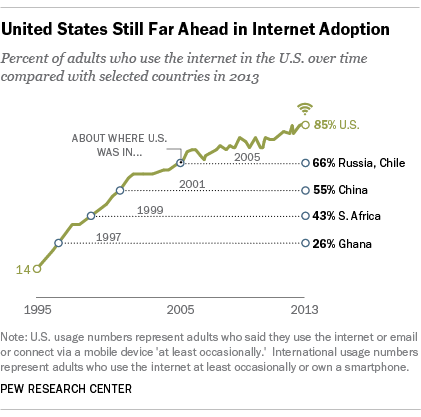

In [30]:
test_dataset[3][1]['content'][0]['image']

In [32]:
output = generate_text_from_sample(model, processor, test_dataset[3])
print(output)

 The chart illustrates the percentage of adults who use the internet in the United States compared with selected countries in 2013. The data is presented as a line graph, with the x-axis showing the year and the y-axis representing the percentage of adults who use the internet.

The data reveals that the United States has consistently had the highest percentage of adults using the internet among the selected countries. In 2013, 85% of adults in the U.S. used the internet, compared to 66% in Russia, 55% in China, 43% in South Africa, and 26% in Ghana.

Interestingly, the percentage of adults using the internet in the U.S. has been steadily increasing over the years. From 14% in 1995 to 85% in 2013, the U.S. has made significant progress in internet adoption. This trend is particularly evident in the last decade, with the percentage increasing from 14% in 1995 to 85% in 2013.

In contrast, the percentage of adults using the internet in Russia, Chile, China, and Ghana has been relatively 